In [ ]:
!pip install mediapipe opencv-python

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [ ]:
# VIDEO FEED
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow('Mediapipe Feed', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
#kamerayı açıyor
#qye basınca kapat        
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap = cv2.VideoCapture(0)
## mediapipe kullanımı
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # open cv BGR formatında ama mediapipe RGB istiyor
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # tam tersi
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # eklem noktalarını çiz. ilki noktalar için ikincisi bağlantı çizgileri için
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
mp_drawing.DrawingSpec??

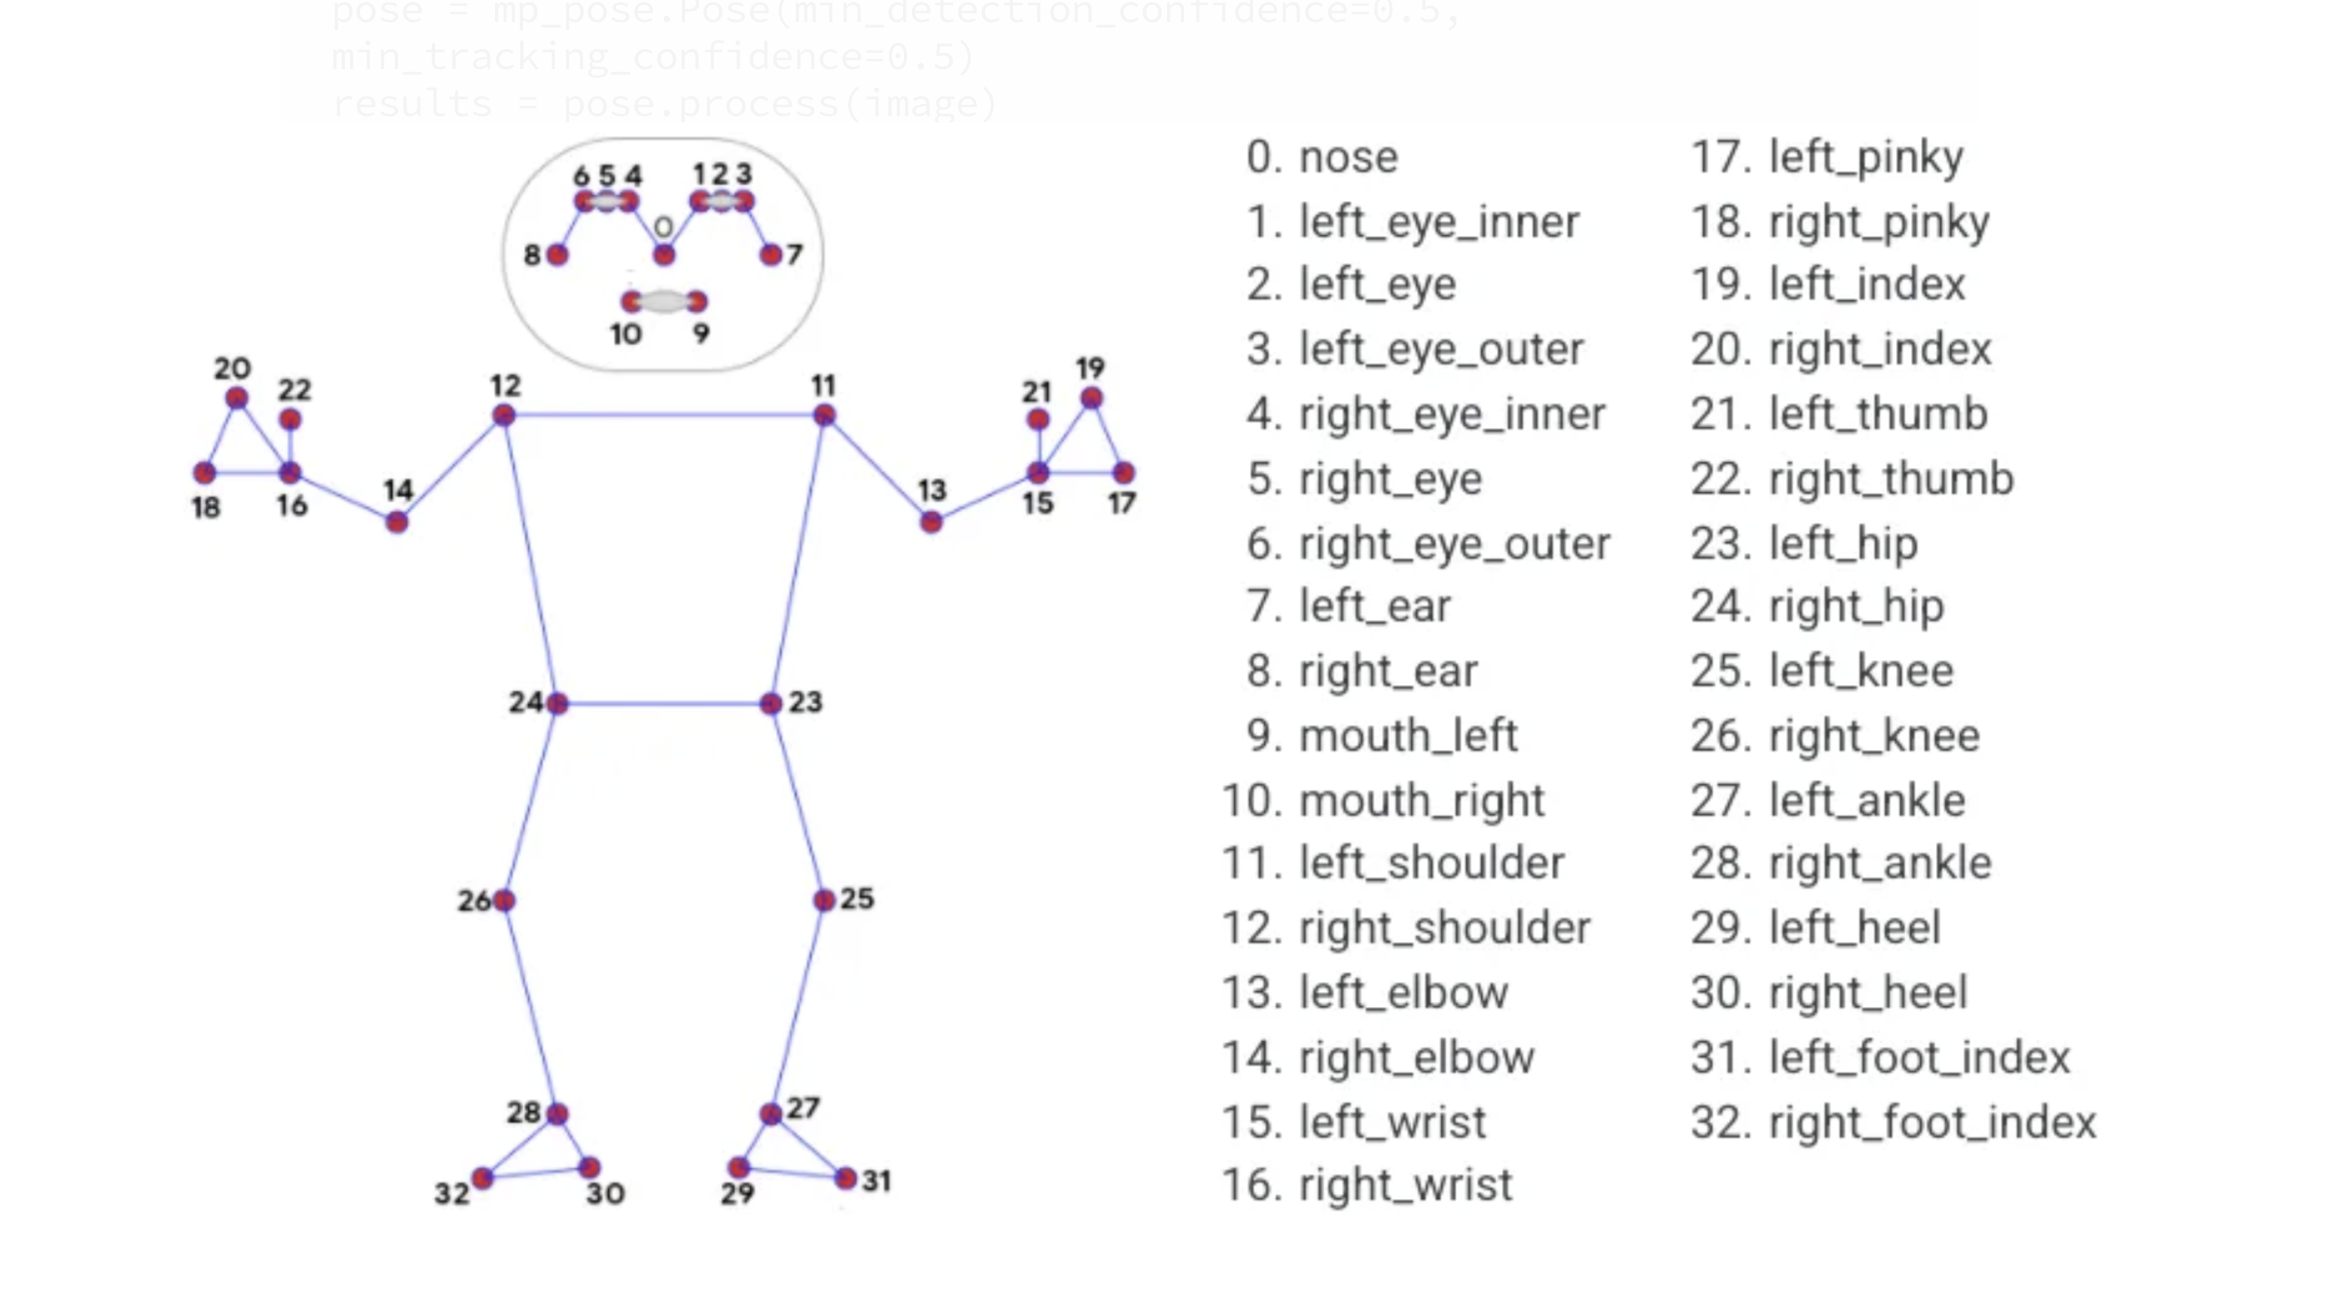

In [ ]:
cap = cv2.VideoCapture(0)
## mediapipe kullanımı
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        # open cv BGR formatında ama mediapipe RGB istiyor
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
      
        # Make detection
        results = pose.process(image)
    
        # tam tersi
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        #tüm eklemlerin konum bilgisi
        try:
            landmarks = results.pose_landmarks.landmark
            print(landmarks)
        except:
            pass
        
        # eklem noktalarını çiz. ilki noktalar için ikincisi bağlantı çizgileri için
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )               
        
        cv2.imshow('Mediapipe Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
len(landmarks)

In [ ]:
for lndmark in mp_pose.PoseLandmark:
    print(lndmark)

In [ ]:
def calculate_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    if angle > 180.0:
        angle = 360 - angle
    return angle

In [ ]:
l_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
r_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
l_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
r_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
l_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
r_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
l_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
r_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x, landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

In [ ]:
tuple(np.multiply(r_shoulder, [640, 480]).astype(int))

In [ ]:
def analyze_inline_lunge(landmarks, image, draw=True):
    h, w, _ = image.shape

    def lm_xy(landmark_name):
        lm = landmarks[mp_pose.PoseLandmark[landmark_name].value]
        return [lm.x * w, lm.y * h]

    # Noktaları al
    l_hip = lm_xy("LEFT_HIP")
    l_knee = lm_xy("LEFT_KNEE")
    l_ankle = lm_xy("LEFT_ANKLE")

    r_hip = lm_xy("RIGHT_HIP")
    r_knee = lm_xy("RIGHT_KNEE")
    r_ankle = lm_xy("RIGHT_ANKLE")

    l_shoulder = lm_xy("LEFT_SHOULDER")
    r_shoulder = lm_xy("RIGHT_SHOULDER")

    # Dizlerin x eksenindeki konumlarına göre öndeki bacağı tespit et
    if l_knee[1] < r_knee[1]:  # Sol diz daha aşağıda (yani önde)
        front_hip, front_knee, front_ankle = l_hip, l_knee, l_ankle
        back_hip, back_knee, back_ankle = r_hip, r_knee, r_ankle
        torso_ref = l_shoulder
        front_leg_label = "Left"
    else:  # Sağ diz önde
        front_hip, front_knee, front_ankle = r_hip, r_knee, r_ankle
        back_hip, back_knee, back_ankle = l_hip, l_knee, l_ankle
        torso_ref = r_shoulder
        front_leg_label = "Right"

    # Açıları hesapla
    front_knee_angle = calculate_angle(front_hip, front_knee, front_ankle)
    back_knee_angle = calculate_angle(back_hip, back_knee, back_ankle)
    torso_angle = calculate_angle(torso_ref, front_hip, front_knee)

    # Görselleştir
    if draw:
        cv2.putText(image, f'{front_leg_label} Front Knee: {int(front_knee_angle)}',
                    tuple(np.int32(front_knee)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2.putText(image, f'Back Knee: {int(back_knee_angle)}',
                    tuple(np.int32(back_knee)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2.putText(image, f'Torso Angle: {int(torso_angle)}',
                    tuple(np.int32(front_hip)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200,255,200), 2)

    # Basit form değerlendirme
    status = "✔ Good Form"
    if front_knee_angle < 80 or front_knee_angle > 120:
        status = "✖ Adjust front leg"
    elif torso_angle < 150:
        status = "✖ Keep torso upright"
    
    cv2.putText(image, status, (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1,
                (0,255,0) if "✔" in status else (0,0,255), 3)

    return image, {
        "front_knee": front_knee_angle,
        "back_knee": back_knee_angle,
        "torso": torso_angle,
        "status": status,
        "front_leg": front_leg_label
    }


In [ ]:
cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        results = pose.process(image)
        
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            landmarks = results.pose_landmarks.landmark
            
            # 📌 Burada bizim fonksiyonu çağırıyoruz!
            image, analysis_info = analyze_inline_lunge(landmarks, image, draw=True)

        except:
            pass

        # Landmark çizimleri
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                  mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))               
        
        cv2.imshow('Lunge Analyzer', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()